# Introduction
#### This graphical summary has the following sections
- Preprocessing
- Topic modeling
- Document clustering accross topic hierarchy
- Topic hierarchy visualization

## Preprocessing
### Steps
- Full texts were collected to local Zotero library using [Zotero connector](https://www.zotero.org/download/connectors)
- Text was extracted using [PyPDF2](https://pypdf2.readthedocs.io/en/3.0.0/)
- Punctuation was removed using [nltk]() and [regular expressions]()
- Texts were tokenized using [nltk]()
- Tokens that occurred in a document less than 3 or more than 950 times were removed as suggested in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.).
- Additionally tokens that consisted of the same two character combination by more than 50% of length were removed. 
    - It was discovered via manual inspection of pre-processed dataset that this step helps to reduce number of uninformative tokens<br>(also see Figure 1 and 2).
- Stop word removal was conducted using stop word list from [nltk]() that was extended to reduce the number of uninformative terms.
- Coocurrence counts was calculated for both datasets using custom python script with window size of 10 tokens.
- The corpus and coocurrence counts were saved in a format accepted by the [BigARTM library](https://docs.bigartm.org/en/latest/api_references/python_interface/dictionary.html?highlight=cooc#artm.Dictionary.gather) and used to construct hierarchical topic models.

In [1]:
# Imports & setups
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import artm
from wordcloud import WordCloud
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nlp_data_path = '../Data/metadata/nlp_tf_1.csv'
bit_data_path = '../Data/metadata/bit_tf_1.csv'

nlp_data = pd.read_csv(nlp_data_path).sort_values(by='max_dimer_freq', ascending=False)
bit_data = pd.read_csv(bit_data_path).sort_values(by='max_dimer_freq', ascending=False)

def df_tf_plot(data, title:str=None, threshold=0.5, ax=None):
    count_by_dim_freq = data.groupby('max_dimer_freq').agg({'term':'count'}).reset_index()
    if ax is None:
        ax = plt.gca()
    count_by_dim_freq.plot.bar(x='max_dimer_freq', y='term', legend=None,ax=ax)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_ylabel('term_count')

def plot_wordcloud(term_list:list, title:str=None, ax=None):
    long_string = ','.join(term_list)
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    
    # Adjust the plotting based on whether an ax is provided
    if ax is not None:
        # Use the provided axes object for plotting
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')  # Hide the axes
        if title is not None:
            ax.set_title(title)  # Set title if provided
    else:
        # No axes object provided, use plt to create and show the plot
        plt.figure(figsize=(6, 4))  # Optional: Adjust figure size
        plt.imshow(wordcloud, interpolation='bilinear')
        if title is not None:
            plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
           


def check_threshold(data,value=0.5):
    print(f'Testing with dimer frequency threshold = {value}.')
    noise = data[data['max_dimer_freq']>=value]
    df_tf_plot(noise, title='Noise term distribution by dimer frequency')
    plot_wordcloud(noise['term'], title='Noise wordcloud')
    clean = data[data['max_dimer_freq']<value]
    display(noise.tail(15))
    df_tf_plot(clean, title='Clean data term distribution by dimer frequency')
    plot_wordcloud(clean['term'], title='Clean data wordcloud')

def grid_plot(data, step=0.1):
    thresholds = np.arange(0, 1.1, step)
    nrows = len(thresholds)  # Determined by the number of thresholds
    ncols = 4  # Fixed number of columns: two for df_tf plots, two for word clouds
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))  # Adjusted figsize for better layout
    
    for i, threshold in enumerate(thresholds):
        noise = data[data['max_dimer_freq'] >= threshold]
        clean = data[data['max_dimer_freq'] < threshold]
        
        # Adjusting call to df_tf_plot and plot_wordcloud to use current axis
        if not noise.empty:
            df_tf_plot(noise, title=f'Noise >= {threshold:.1f}', threshold=threshold, ax=axs[i, 0])
            plot_wordcloud(noise['term'].tolist(), title='Noise Wordcloud', ax=axs[i, 2])
        else:
            axs[i, 0].text(0.5, 0.5, 'No noise data', ha='center', va='center', transform=axs[i, 0].transAxes)
            axs[i, 2].axis('off')
        
        if not clean.empty:
            df_tf_plot(clean, title=f'Clean < {threshold:.1f}', threshold=threshold, ax=axs[i, 1])
            plot_wordcloud(clean['term'].tolist(), title='Clean Wordcloud', ax=axs[i, 3])
        else:
            axs[i, 1].text(0.5, 0.5, 'No clean data', ha='center', va='center', transform=axs[i, 1].transAxes)
            axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

## Comments on grid plot structure
- The grid plots shows number of tokens by the maximum observed fraction <br>of token length that consisted of the same two character combination. 
- Each row shows result of a dataset split, given fraction of length threshold.
- The first column shows the counts for tokens above threshold (termed Noise here).
- The second column shows the counts for tokens below threshold (termed Clean here).
- The third column shows the wordcloud plot for the "Noise" tokens.
- The fourth column shows the wordcloud plot for the "Clean" tokens.

## Figure 1: Repeated dimer filtering - natural language processing dataset

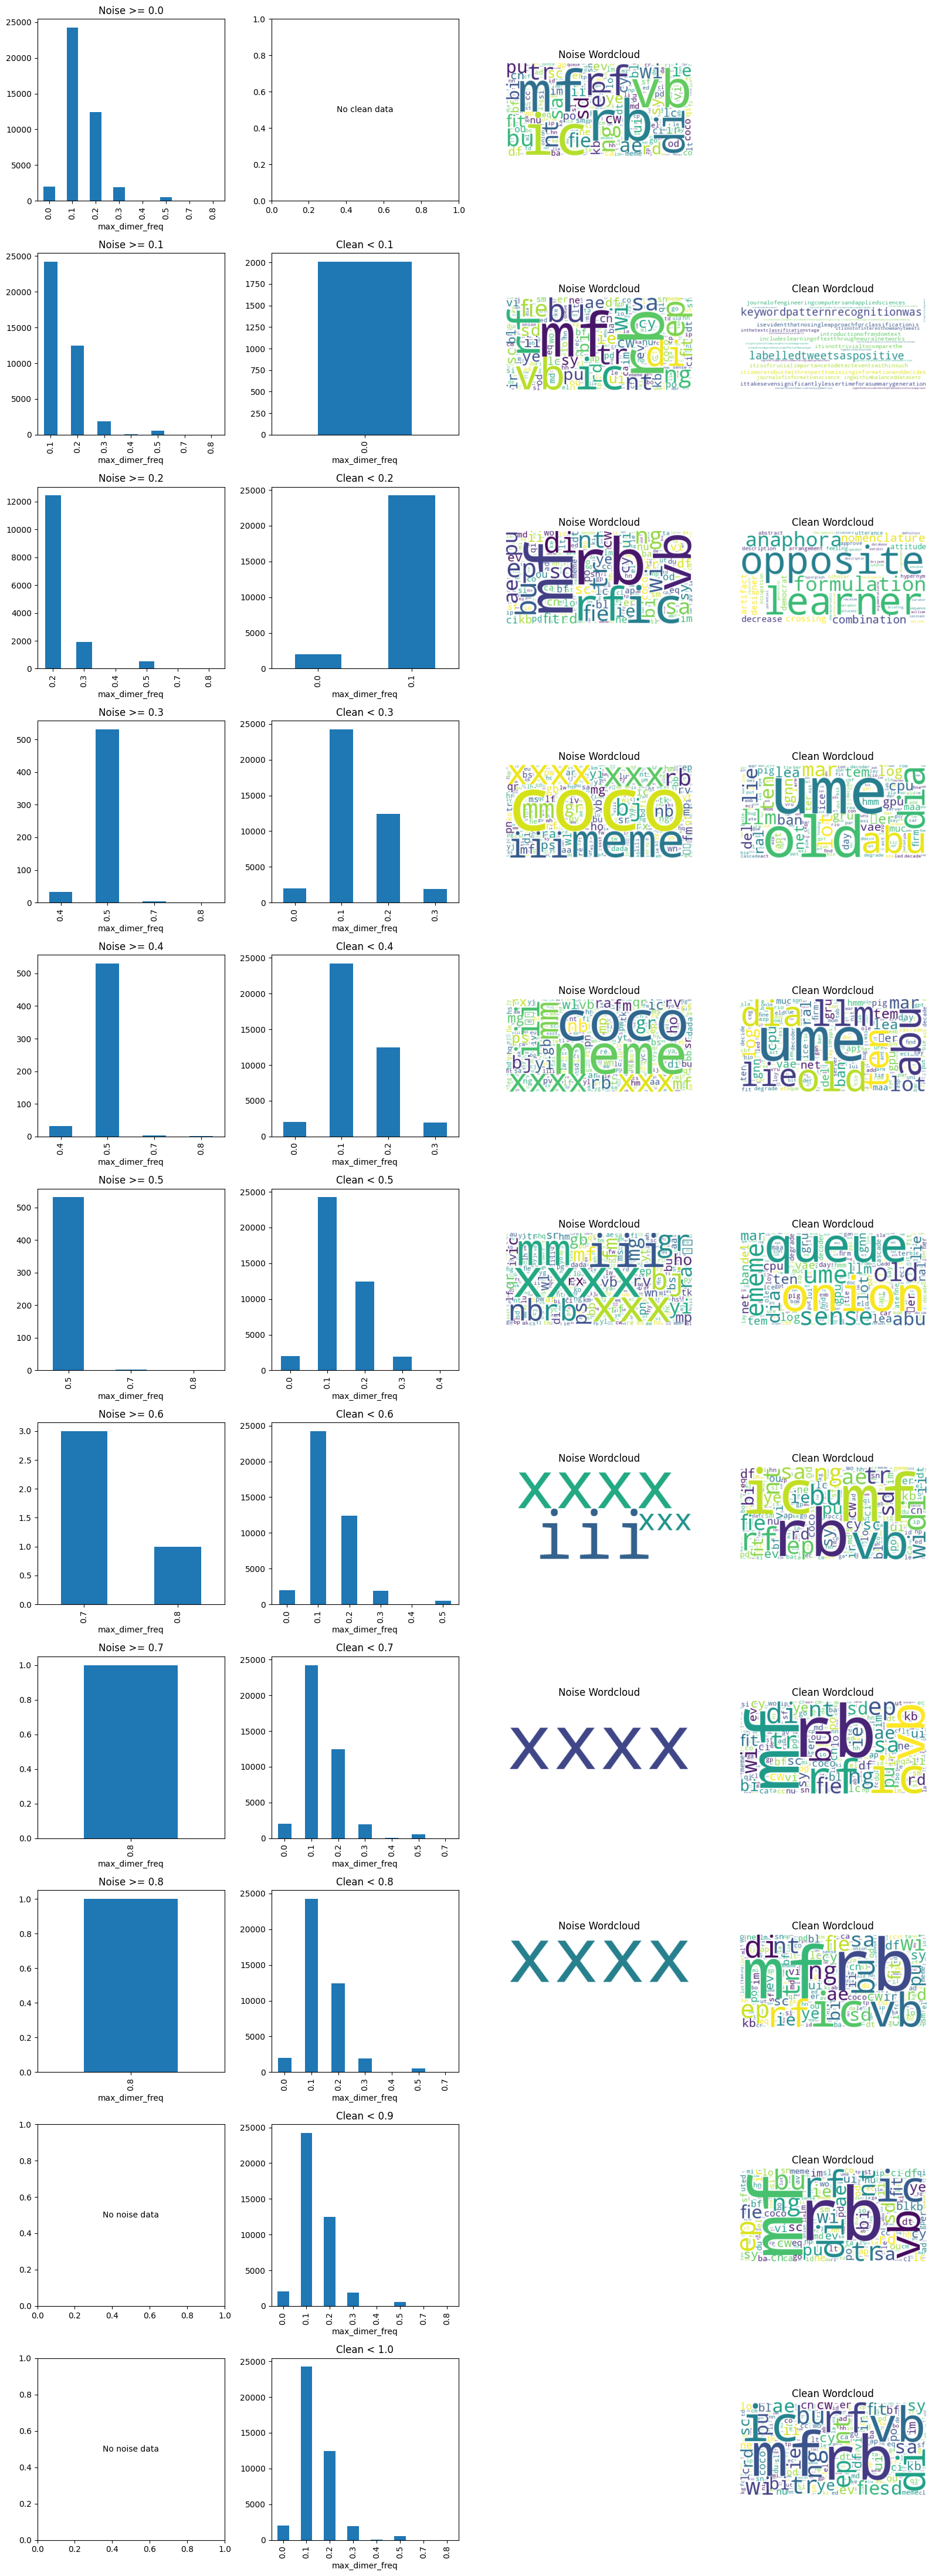

In [3]:
grid_plot(nlp_data)

## Figure 2: Repeated dimer filtering - bioinformatics dataset

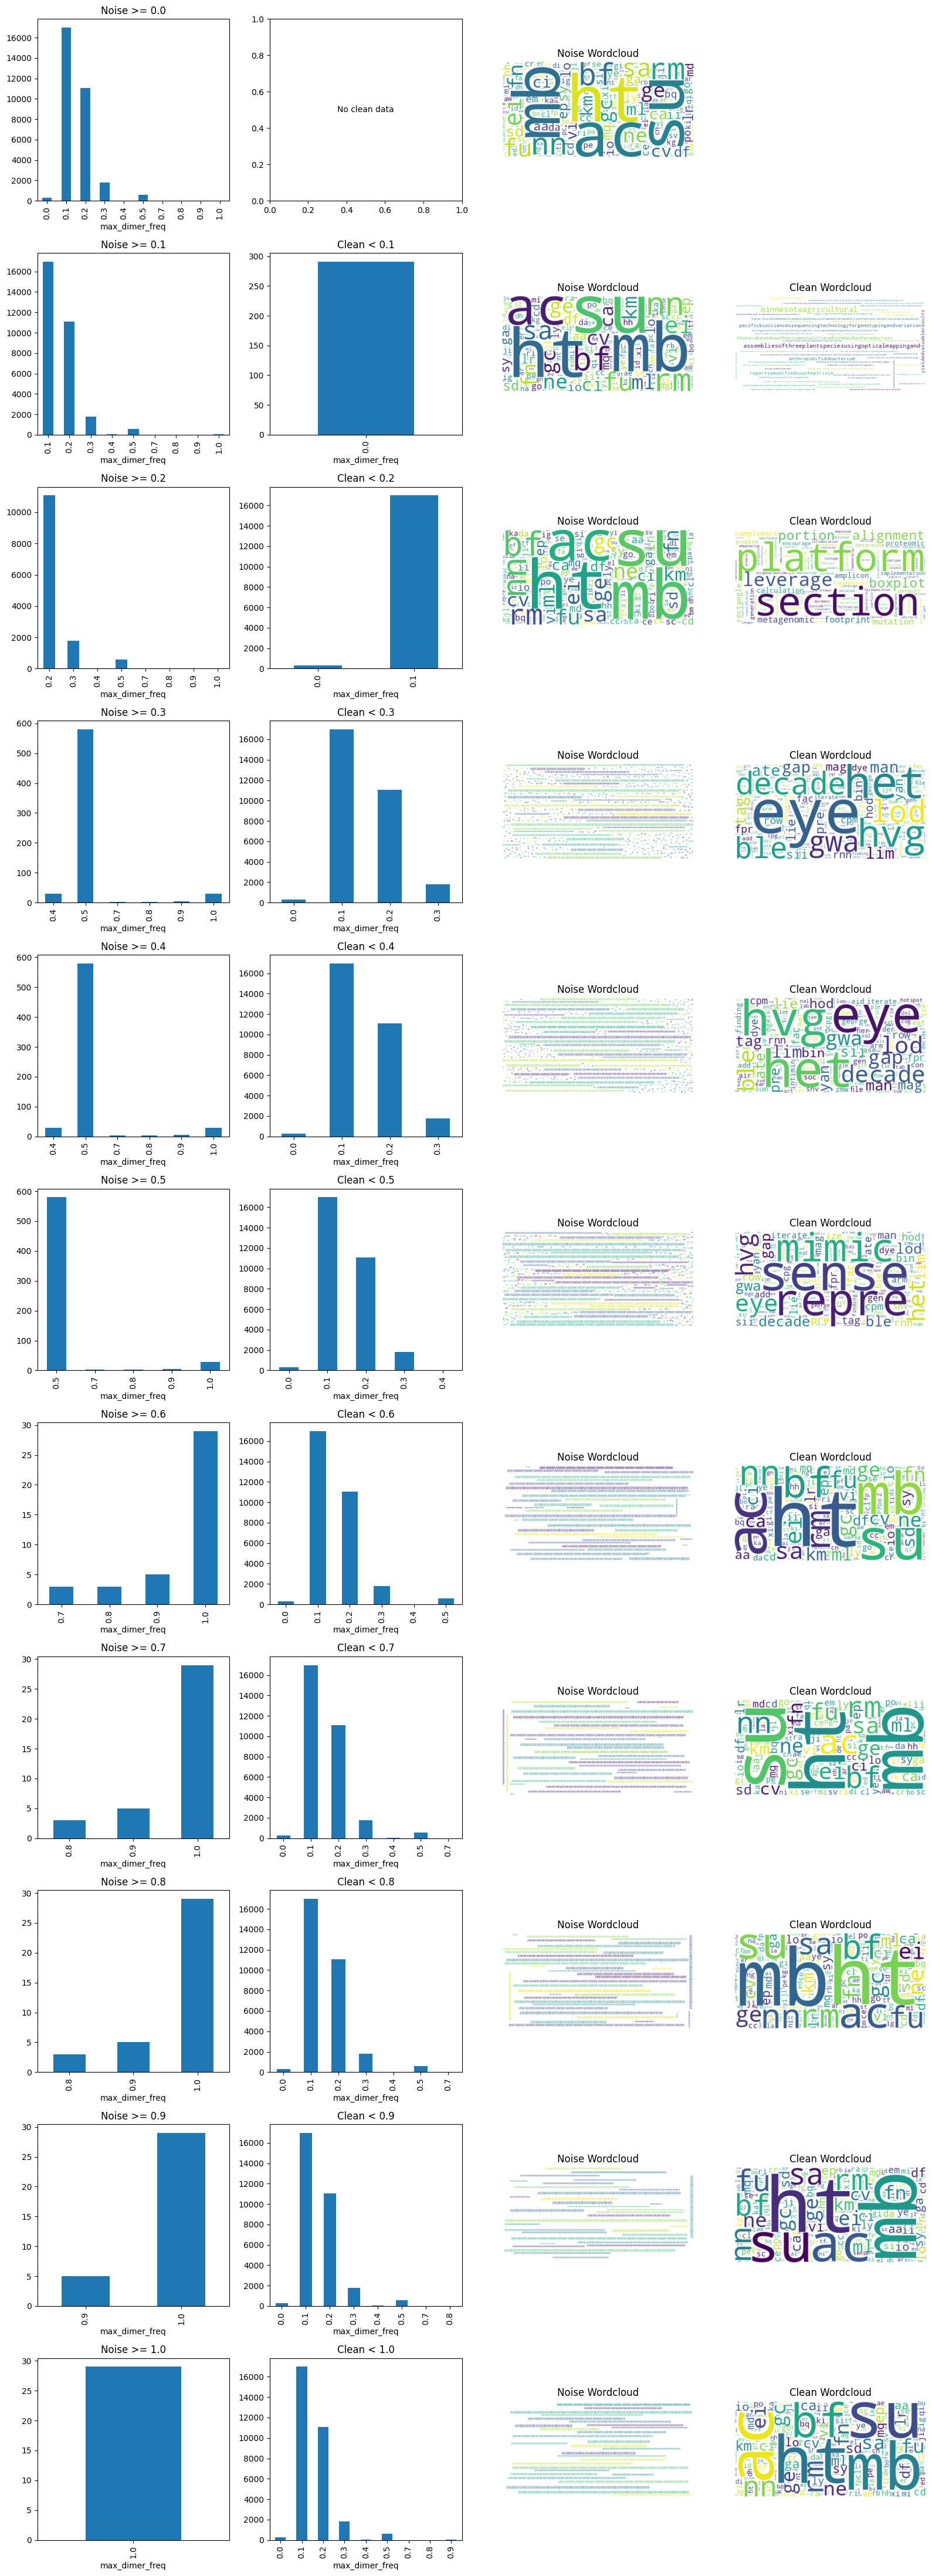

In [4]:
grid_plot(bit_data)

## Topic modeling
- BigARTM-based implementation of the approach described in [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) was used
- As a moment of novelty - the model architecture discussed in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.) for single-level topic model was implemented here for the hierarchical case with some adjustements.
- Finally the calculation of Renyi entropy was implemented based on [Koltsov, S. et al. (2021)](https://doi.org/10.7717/peerj-cs.608) in order to attempt optimizing the number of topics along with other parameters of the model using the approaches discussed in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.) (to be implemented).
- The quality metric function was adopted from [BigARTM documentation](https://docs.bigartm.org/en/latest/tutorials/python_tutorial.html) to track the quality metrics for each level accross trainin iterations as suggested in [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) and [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.)

## Document clustering accross topic hierarchy
- Hierarchical topic model based on [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) allows to calculate a topic distribution for each document in the corpus.
- Such vectors corresponds to a discrete probability distribution and can be used to compare the documents at a given level of topic hierarchy, similarly to neural network embeddings. 
- Additionally for each level of topic hierarchy (except the first one) it is possible to get vectors representing super-topics in terms of sub-topics. This allows to treat super-topics (at the higher level of hierarchy) as pseudo-documents and include them into document matrix. This is the basis of the approach for calculating topic hierarchy described by [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05).
- Calculating Hellinger distance between such vector (documents and pseudo-documents) was suggested as one of the quality metrics for the model in the original publication.
- Here it was attempted to generalize this approach by implementing document similarity calculation using three additional steps:  
    - First, given a matrix of topic-based document distributions (termed Phi), and a matrix of pseudo-document distributions (termed Psi) a combined matrix is generated. 
    - Next from such combined matrix the square pairwise distance matrix is calculated using Hellinger distance formula. 
    - Finally the distance matrix is converted to similarity matrix using Bhattacharyya coefficient as discussed in [Kitsos, C.P. and Nisiotis, C.-S. (2022)](https://doi.org/10.2478/bile-2022-0006).
    - Using the resulting similarity matrix it was possible to perform spectral clustering of documents to assign groups of topic-based similarity within each level of topic hierarchy. 
    - It was also possible to visually represent documents at each level of hierarchy in two-dimensional space using Multidimensional scaling on the original distance matrix to generate a scatter plot.
    - This plot was additionally annotated with document labels and connections between documents where pairwise Hellinger distance values were below the specified threshold. The resulting plots are shown in figures 4 and 7.
    - Tables illustrate correspondance between maximum probability topic index and cluster.
    - The human-in-the-loop evaluation of actual document similarity within discovered groups is to be conducted.


    
## Topic hierarchy visualization
- In order to show the resulting hierarchy and the connections discovered by the model an additional function was developed to represent all levels of topic hierarchy and include any connections between the layers with model-assigned probability value below a specified threshold.
- The resulting plots are shown in figures 5 and 8.

In [5]:
# To be used as target function to optimize model's parameters
def get_renyi_entropy(model, dictionary, num_topics):
    '''
    Function to calculate Renyi entropy 
    for hierarchical topic model 
    based on https://doi.org/10.7717/peerj-cs.608
    '''
    
    #Getting token probability distribution for each topic
    phi = model.get_phi()
    phi_np = phi.to_numpy()
    
    #Getting number of words in the dictionary
    W = int(str(dictionary).split(" ")[-1][:-1].split("=")[-1])
    
    #Calculating uniform distribution threshold value
    p_uniform = 1/W
    
    #Filtering the phi_wt matrix based on threshold
    phi_gt_uniform = phi_np[phi_np > p_uniform]
    
    #Getting number of entries above threshold
    N = len(phi_gt_uniform)
    
    #Getting number of topics in the model
    T = num_topics
    
    #Calculating Gibbs-Shannon entropy
    S = np.log(N/(W*T))
    
    #Calculating internal energy
    E = -np.log((1/T)*np.sum(phi_gt_uniform))
    
    #Calculating deformation parameter
    q = 1/T
    
    #Calculating Renyi entropy value
    S_qR = (-q*E+S)/(q-1)
    return S_qR

In [6]:
def train_hier_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    regularizers:list,
    num_levels:int,
    topics_per_level:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
) -> (artm.ARTM, list):
    '''
    Wrapper to train hierarchical unimodal topic model
    using the algorithm suggested by https://doi.org/10.1007/978-3-030-61705-9_24
    '''
   
    
    # Defining the hierarchical model object as container for models to represent levels
    model_artm = artm.hARTM(
        regularizers = regularizers,
        scores=scores,
        cache_theta=True
    )
    
    
    #Adding levels to the model
    level_dict = {} # to access each level model by its id
    for i in range(num_levels):
        level_id = f'level_{i}'
        level_dict[level_id] = model_artm.add_level(
            num_topics=topics_per_level[i],
            parent_level_weight = 0.5
        )

        #Initialize - as required by the documentation
        #https://docs.bigartm.org/en/latest/api_references/python_interface/hARTM.html#artm.hARTM.add_level
        level_dict[level_id].initialize(dictionary = cooc_dict)
        level_dict[level_id].fit_offline(
            batch_vectorizer      = batch_vectorizer, 
            num_collection_passes = 1)
        
    #Setting regularization coefficient for the 1st training session
    #Note - all levels share the same regularizers and regularization parameters
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #Performing first training session of n1 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Setting regularization coefficient for the 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Performing second training session of n2 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Setting regularization coefficient for the 3rd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Performing third training session of n3 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Setting regularization coefficient for the 4th training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Performing fourth training session of n4 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n4)
    
    '''
    The steps below allow to expose parameters of the model and
    perform target function calculation which will be required to
    optimize parameters of the model.
    '''
    
    #Calculating Renyi entropy for each level and on-average
    S_qR_dict = {}
    mean_S_qR = 0
    for i in range(num_levels):
        level_id = f'level_{i}'
        level = level_dict[level_id]
        S_qR = get_renyi_entropy(
            model=level, 
            dictionary=dictionary,
            num_topics=topics_per_level[i]
        )
        S_qR_dict[f'{level_id}'] = S_qR
        #Average Renyi entropy accross levels to use in score calculation
        mean_S_qR += S_qR/num_levels
    
    #Exposing regularization coefficients
    parameters = {
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ],
    }
    
    #Generating parameter list
    flat_params = sum(list(parameters.values()),[])    
    
    #Calculating target function for the model with given parameters
    #Target function defined based on https://doi.org/10.1007/978-3-030-61705-9_24
    #In terms of topic coherence score calculated using the core (p>0.3) for each topic
    min_fc_list = []
    mean_fc_list = []
    for i in range(num_levels):
        min_fc_list.append(min(model_artm.get_level(i)._score_tracker['TopKernelScore Coherence'].coherence[-1].values()))
        mean_fc_list.append(model_artm.get_level(0)._score_tracker['TopKernelScore Coherence'].average_coherence[-1])
    min_fcoherence = np.array(min_fc_list)
    mean_fcoherence = np.array(mean_fc_list)
    fitness = np.sum(min_fcoherence + mean_fcoherence)
        
    return model_artm, flat_params, fitness, parameters, mean_S_qR

In [7]:
def print_measures(model:list):
    '''
    Function to summarize final score values of single level.
    Additionally plots quality metric values accross training iterations for single level.
    '''
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

In [8]:
def print_tpc_top_tkns(model, num_levels):
    for i in range(num_levels):
        print(f'\nlevel{i}\n')
        for topic_name in model.get_level(i).topic_names:
            print(
                topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

In [9]:
def hellinger_distance(p, q):
    '''
    Function to calculate Hellinger distance 
    between two discrete probability distribution vectors.
    Based on https://doi.org/10.21469/22233792.2.2.05.
    '''
    #Ensure the vectors are numpy arrays and normalized to sum to 1
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    #Calculate the Hellinger distance
    distance = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    return distance

In [10]:
def get_distance_matrix(model, level_id):
    '''Calculates pairwise Hellinger distances from combined theta and psi matrices'''
    
    if level_id == 0:
        #Psi is only available if current level has parent level associated with it
        theta_psi = model.get_level(level_id).get_theta()
    else:
        #getting document embeddings for a given level
        theta = model.get_level(level_id).get_theta()

        #getting topic embeddings in terms of parent level 
        psi = model.get_level(level_id).get_psi()
        #Including embeddings for parent topics with documents
        theta_psi = theta.join(psi)

    #Distance matrix between documents using hellinger distance
    hlg_matrix = np.zeros((len(theta_psi.columns), len(theta_psi.columns)))
    for i, col1 in enumerate(theta_psi.columns):
        for j, col2 in enumerate(theta_psi.columns):
            hlg_matrix[i, j] = hellinger_distance(theta_psi[col1].values, theta_psi[col2].values)
    hlg_df = pd.DataFrame(hlg_matrix, columns=theta_psi.columns, index=theta_psi.columns)
    return hlg_df

In [11]:
def get_spectral_clusters(distance_matrix, num_topics):
    '''
    Perform spectral clustering based on pairwise distance matrix 
    and number of topics for a given level of the model.
    Bhattacharyya coefficient is a similarity measure related to Helligner distance,
    based on https://doi.org/10.2478/bile-2022-0006:
        HD = (1 − BC)^1/2
        BC = 1 - HD^2 
    '''
    # Convert the distance matrix to a similarity matrix
    similarity_matrix = 1 - distance_matrix.to_numpy()**2

    # Apply spectral clustering
    clustering = SpectralClustering(n_clusters = num_topics, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)

    # 'labels' now contains the cluster assignments for each point
    return labels

In [12]:
def plot_clustering_results(dm, labels, threshold, level_id, n_components=2):
    '''
    Using Multidimensional Scaling to project distance matrix into 2D or 3D space 
    and visualize connections based on Hellinger distance threshold for a given level of the model.
    Based on https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/
    '''
    # Initialize MDS with the specified number of components (2D or 3D)
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42) #to fix document positions on rerun
    
    #Get document names from distance matrix to annotate the points
    doc_names = dm.columns
    
    #Transform dm into required number of dimensions for visualization using MDS
    data_transformed = mds.fit_transform(dm.to_numpy())

    # Create a plot based on the number of components
    fig = plt.figure()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_func = ax.scatter
    else:
        ax = fig.add_subplot(111)
        plot_func = ax.scatter

    # Configure color map
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster
    for label, color in zip(unique_labels, colors):
        idx = np.where(labels == label)[0]  # Indices of points in the current cluster
        if n_components == 3:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                data_transformed[idx, 2], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )
        else:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )

        # Annotate each point in the cluster
        for point in idx:
            text = doc_names[point] if 'topic' not in str(doc_names[point]) else f'{doc_names[point]}_{level_id-1}'
            if n_components == 3:
                ax.text(
                    data_transformed[point, 0], 
                    data_transformed[point, 1], 
                    data_transformed[point, 2], 
                    text, 
                    fontsize=9
                )
            else:
                plt.annotate(
                    text, 
                    (data_transformed[point, 0], data_transformed[point, 1]), 
                    textcoords="offset points",
                    xytext=(5,2),
                    ha='center',
                    fontsize=9
                )

    # Draw connections for distances below the threshold
    for i in range(len(data_transformed)):
        for j in range(i + 1, len(data_transformed)):
            if dm.iloc[i, j] < threshold:
                if n_components == 3:
                    ax.plot([data_transformed[i, 0], data_transformed[j, 0]],
                            [data_transformed[i, 1], data_transformed[j, 1]],
                            [data_transformed[i, 2], data_transformed[j, 2]], 'k-', alpha=0.1)
                else:
                    plt.plot([data_transformed[i, 0], data_transformed[j, 0]],
                             [data_transformed[i, 1], data_transformed[j, 1]], 'k-', alpha=0.1)

    plt.title(f'Spectral Clustering Results with MDS, level {level_id}')
    if n_components == 2:
        plt.xlabel('MDS1')
        plt.ylabel('MDS2')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.75) if n_components == 2 else None
    plt.show()

In [13]:
def plot_hierarchical_connections(model, num_levels, threshold=0.15, spacing = 25, image_width=15):
    '''
    Function to plot connections between topics in different layers
    of the hierarchical topic model based on probability threshold.
    '''
    
    # Extracting topic embedding matrices from the model
    matrix_list = []
    for level_id in range(1,num_levels):
        df = model.get_level(level_id).get_psi()
        df.columns = [f'{c}_{level_id-1}' for c in df.columns]
        df.index = [f'{c}_{level_id}' for c in df.index]
        matrix_list.append(df)

    G = nx.Graph()
    pos = {}
    layer_y = 0  # Y position for the first layer
    y_offset = -5  # Vertical offset for subsequent layers
    
    # Determine the total number of layers for positioning
    total_layers = len(matrix_list) + 1  # +1 to include the 0th layer explicitly

    # Image width for centering
    half_width = image_width / 2

    # Process the first dataframe separately
    first_df = matrix_list[0]
    columns = first_df.columns
    indices = first_df.index

    # Position columns of the first dataframe
    for i, col in enumerate(columns):        
        # Calculate positions
        current_x_positions = half_width - (len(columns) / 2 - i) * spacing
        pos[col] = (current_x_positions, layer_y)
        
    #Adding spacing between the first and 2nd layer
    layer_y += y_offset
    
    # Position indices of the first dataframe as the second layer
    for i, index in enumerate(indices):
        current_x_positions = half_width - (len(indices) / 2 - i) * spacing
        pos[index] = (current_x_positions, layer_y)
    

    # Add edges for the first dataframe based on Hellinger distance threshold
    for col in columns:
        for index in indices:
            if first_df.at[index, col] > threshold:
                G.add_edge(col, index)
                
    # Setting index of the first df as columns of the 2nd df
    columns = first_df.index
                
    # For subsequent dataframes, treat indices as the new layer connected to the previous layer's indices
    for df in matrix_list[1:]:
        new_layer_y = layer_y + y_offset
        new_indices = df.index
        
        
        # Position new indices
        for i, index in enumerate(new_indices):
            new_x_positions = half_width - (len(new_indices) / 2 - i) * spacing
            pos[index] = (new_x_positions, new_layer_y)
        
        # Add edges based on threshold, connecting previous indices to new indices
        for col in columns:  # Previous layer's indices now act as "columns"
            for index in new_indices:
                if df.at[index, col] > threshold:
                    G.add_edge(col, index)
        
        # Update for the next iteration
        layer_y = new_layer_y
        columns = new_indices  # The current indices become "columns" for the next layer

    # Draw the graph
    plt.figure(figsize=(image_width, 3 * total_layers))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, edge_color='k')
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()

In [70]:
def get_clustering_maxp_topic(model, labels, doc_names):
    '''
    Showing top-1 probability topic index vs cluster number for every document in table form.
    '''
    theta = model.get_theta().reset_index(drop=True)
    clusters = doc_names.join(pd.DataFrame(labels, columns=['cluster_id']))
    clusters = clusters.join(pd.DataFrame(theta.idxmax(), columns=['max_p_topic_id']))
    return clusters

# Results for BIOIT set

In [71]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [72]:
#Preparing list of document names
with open(f'{input_folder}bioit_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

In [73]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [74]:
%%time
#Training the model
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 43.2 s, sys: 17.9 s, total: 1min 1s
Wall time: 20.8 s


In [75]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(model, num_levels)


level0

topic_0:  ['data', 'sequencing', 'analysis', 'cells', 'cell', 'dna', 'cancer', 'methods', 'used', 'gene']
topic_1:  ['reads', 'genome', 'read', 'data', 'alignment', 'reference', 'variant', 'sequencing', 'genomes', 'coverage']

level1

topic_0:  ['sequencing', 'dna', 'cancer', 'resistance', 'gene', 'ngs', 'genes', 'using', 'detection', 'protein']
topic_1:  ['variant', 'kraken', 'variants', 'regions', 'normalization', 'benchmark', 'species', 'scone', 'snps', 'wgs']
topic_2:  ['reads', 'genome', 'read', 'alignment', 'assembly', 'coverage', 'genomes', 'reference', 'contigs', 'graph']
topic_3:  ['data', 'analysis', 'cell', 'cells', 'methods', 'metagenomic', 'used', 'expression', 'nat', 'metagenomics']

level2

topic_0:  ['alignment', 'bioinformatics', 'tools', 'algorithms', 'umap', 'mapping', 'short', 'length', 'algorithm', 'fuzzy']
topic_1:  ['genomes', 'contigs', 'lineage', 'contig', 'tree', 'assemblies', 'supplementary', 'assigned', 'samples', 'grapetree']
topic_2:  ['cell', 'ce

### Figure 3. Quality metrics accross training iterations for hierarchical model - bioinformatics dataset


Results for level 0

Sparsity Phi: 0.381 
Sparsity Theta: 0.000
Kernel contrast: 0.891
Kernel purity: 0.938


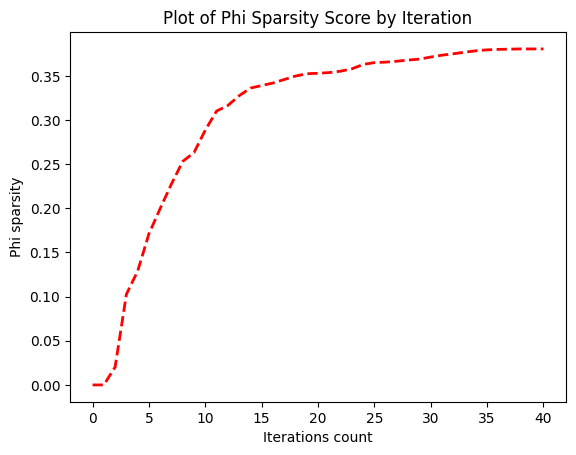

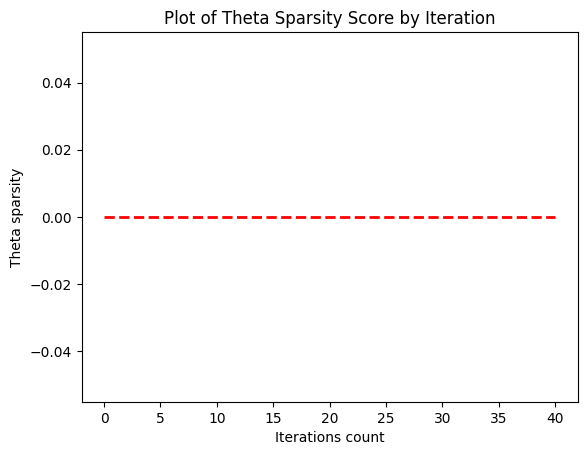

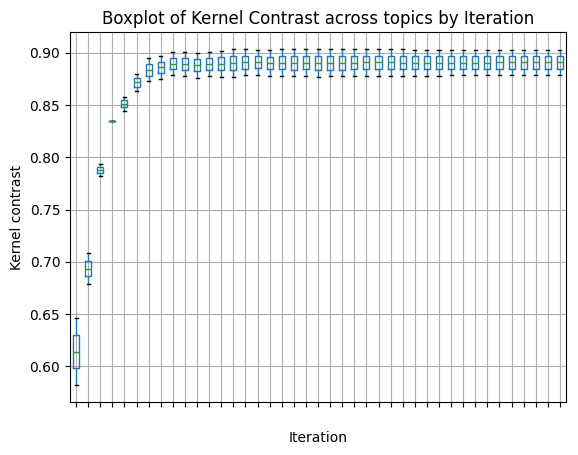

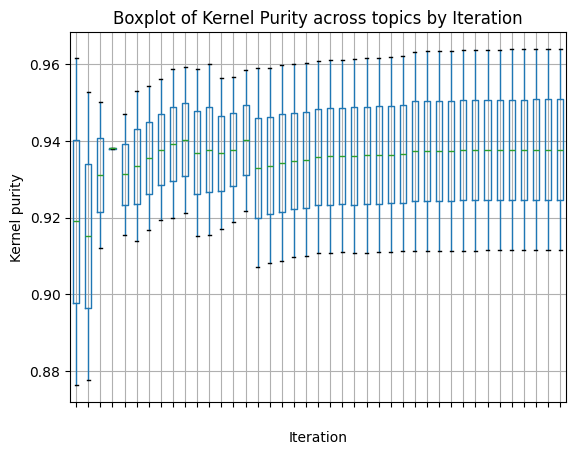

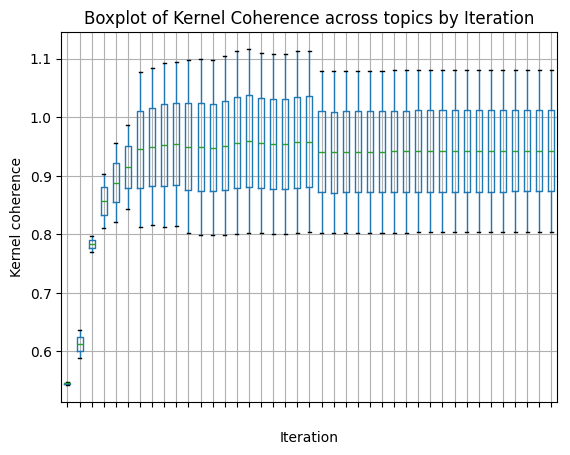


Results for level 1

Sparsity Phi: 0.567 
Sparsity Theta: 0.000
Kernel contrast: 0.846
Kernel purity: 0.890


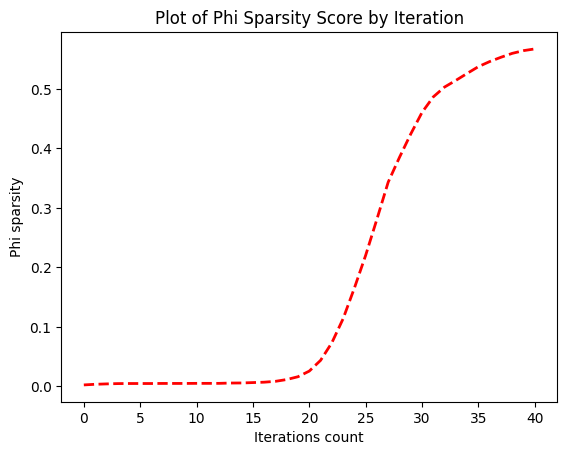

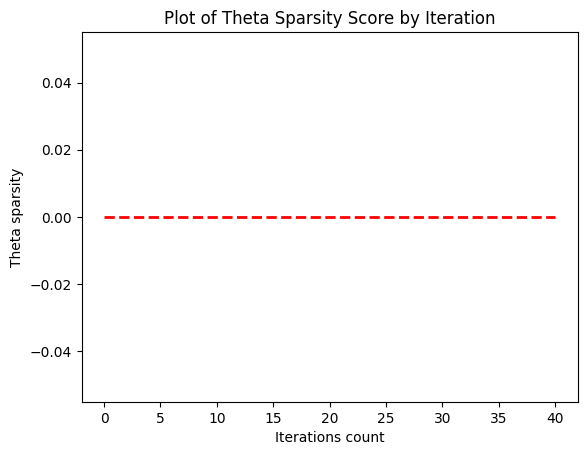

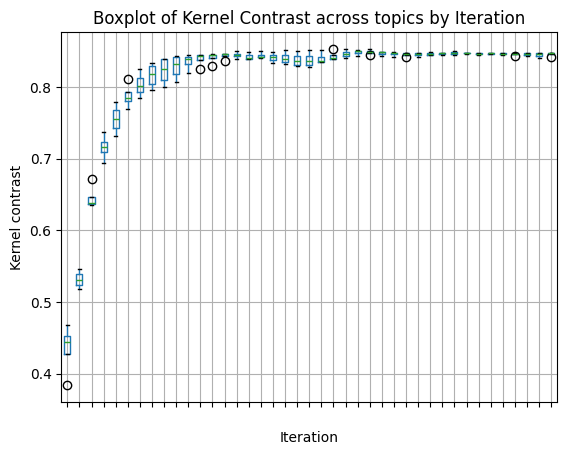

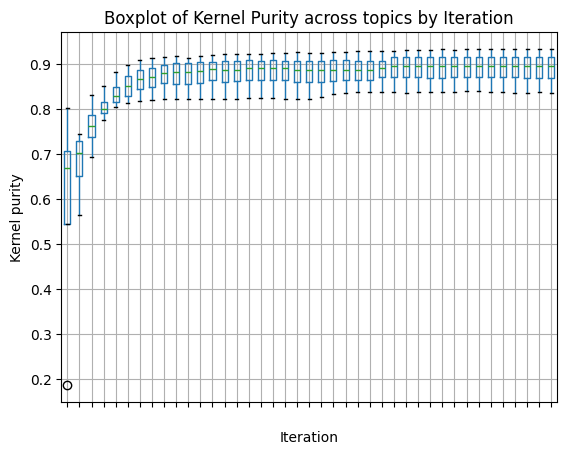

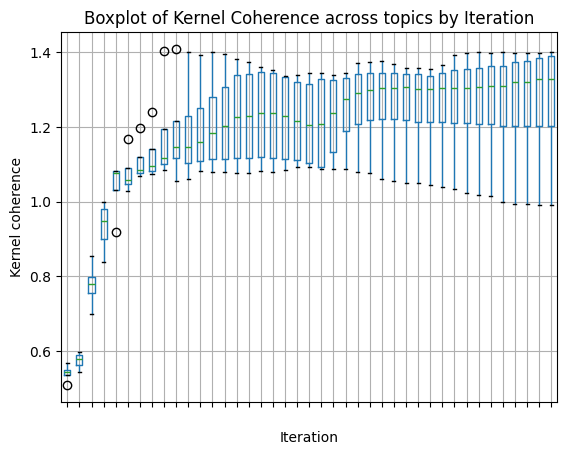


Results for level 2

Sparsity Phi: 0.735 
Sparsity Theta: 0.009
Kernel contrast: 0.839
Kernel purity: 0.879


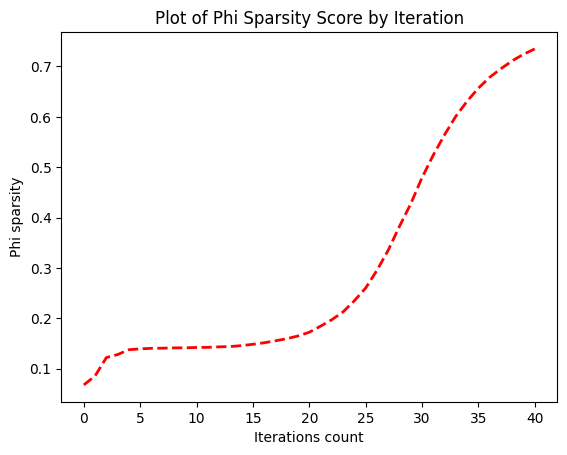

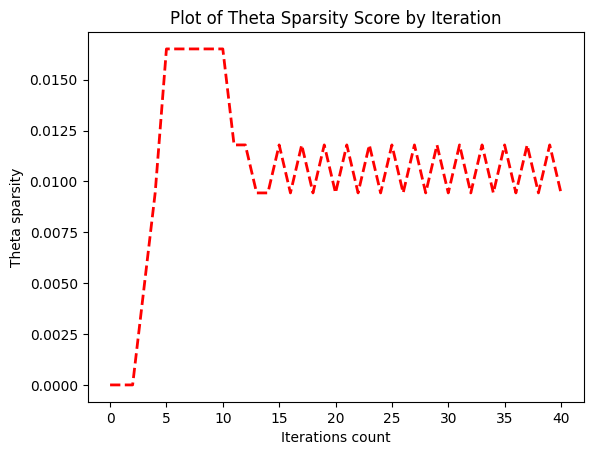

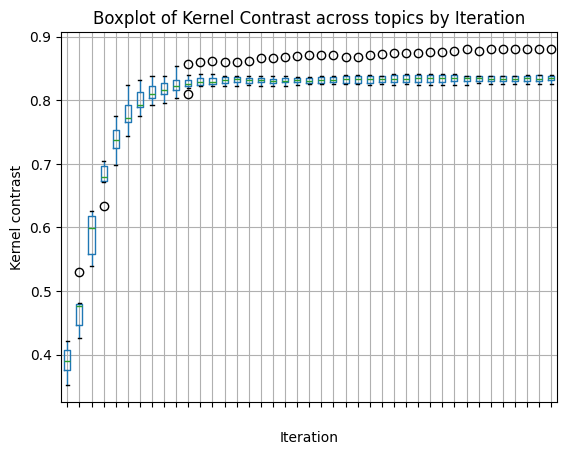

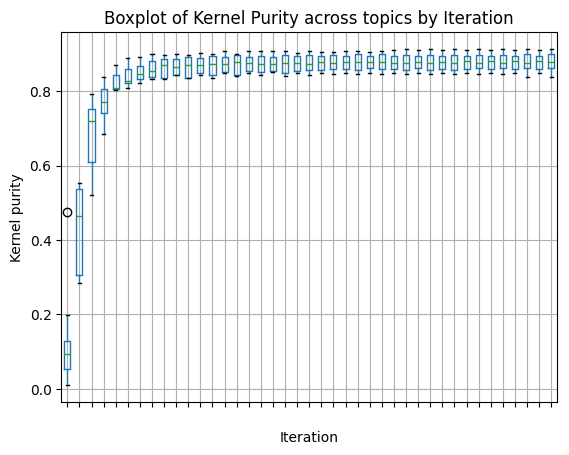

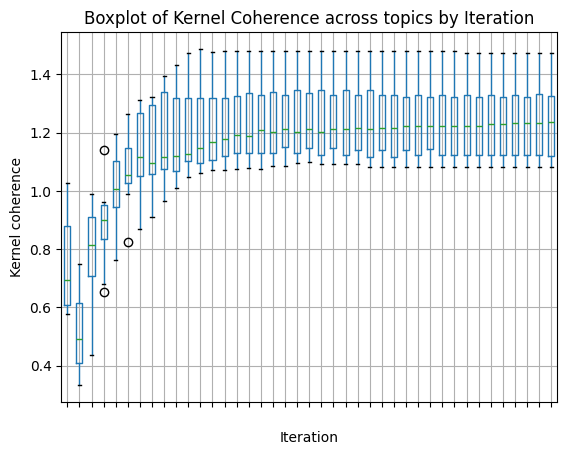


Results for level 3

Sparsity Phi: 0.000 
Sparsity Theta: 0.000
Kernel contrast: 0.461
Kernel purity: 0.388


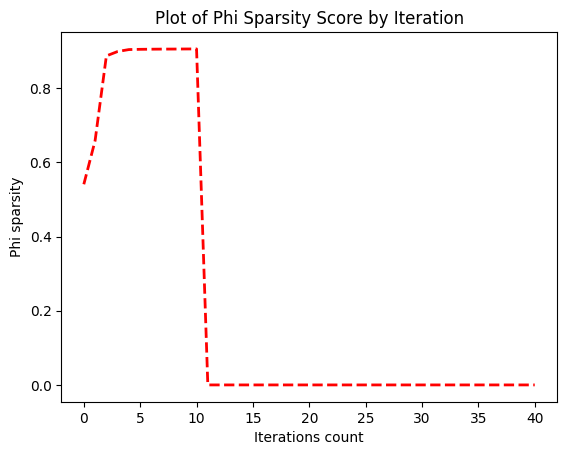

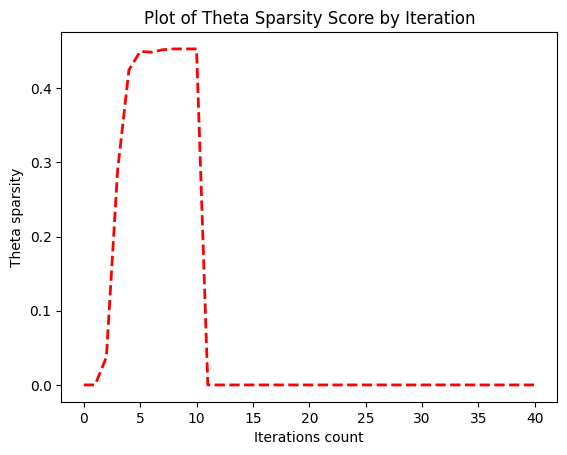

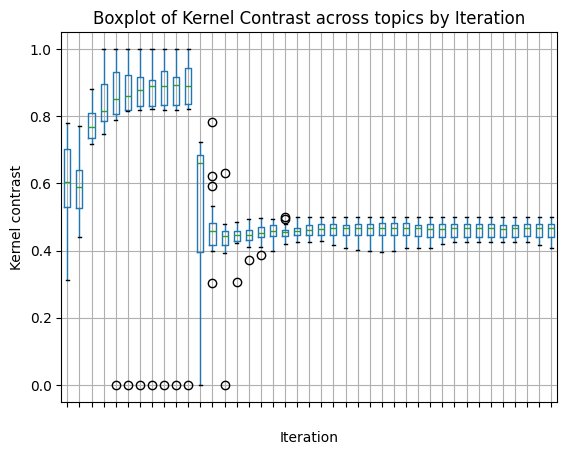

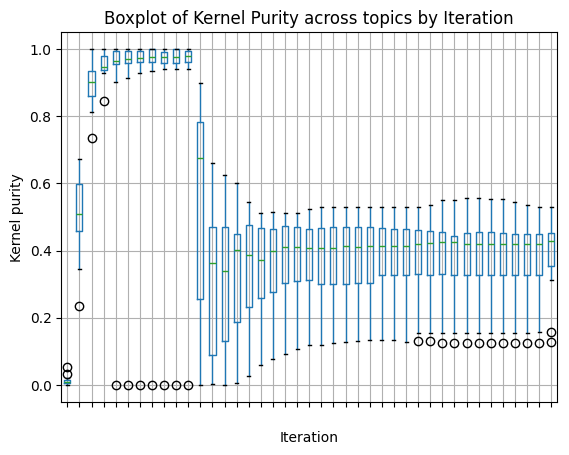

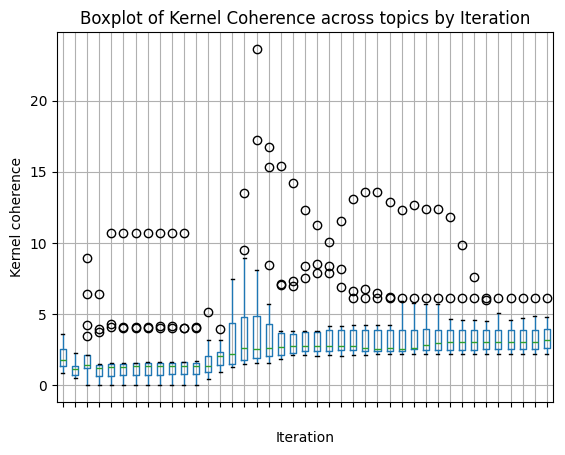

In [76]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(model.get_level(level_id))

### Figure 4. Spectral clustering results - bioinformatics dataset

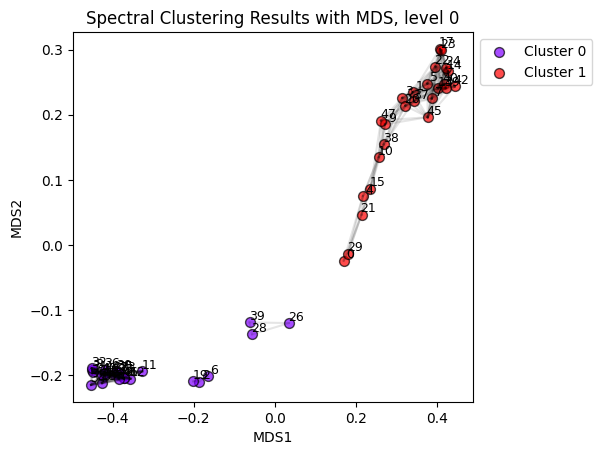

doc_names  cluster_id  max_p_topic_id
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic           0               1
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           0               1
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           0               1
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           0               1
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           0               1
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex           0               1
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           0               1
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome           0               1
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           0               1
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk           0               1
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure           0               1
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           0               1
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           0               1
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           0               1
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           0               1
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           0               1
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           0               1
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           0               1
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           0               1
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           0               1
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati           0               1
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           0               1
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           0               1
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           0               1
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           0               1
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           1               0
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review           1               0
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           1               0
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           1               0
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           1               0
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           1               0
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and           1               0
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           1               0
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           1 

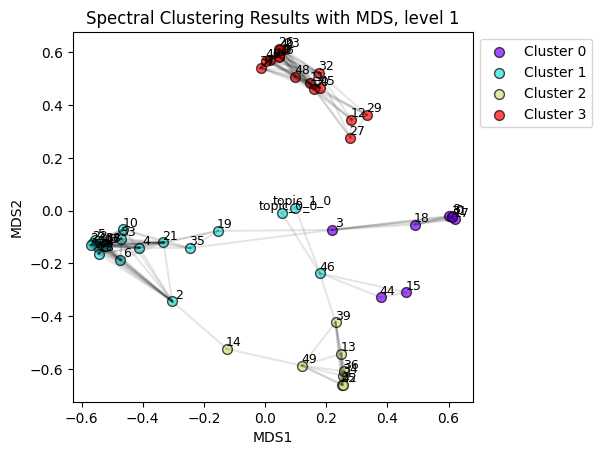

doc_names  cluster_id  max_p_topic_id
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           0               2
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           0               3
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           0               3
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           0               3
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           0               3
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-           0               3
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           0               3
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           0               3
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review           1               0
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic           1               0
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           1               0
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           1               0
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           1               0
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           1               0
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome           1               0
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l           1               0
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           1               0
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           1               0
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           1               0
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           1               0
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           1               0
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           1               0
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           1               0
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           1               0
47               Zhao_et_al._-_2021_-_Entropy-aware_self-training_for_graph_convolutiona           1               0
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           1               2
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           2               2
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease           2               2
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           2               2
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           2               2
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           2               2
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           2               2
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor           2               2
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system           2 

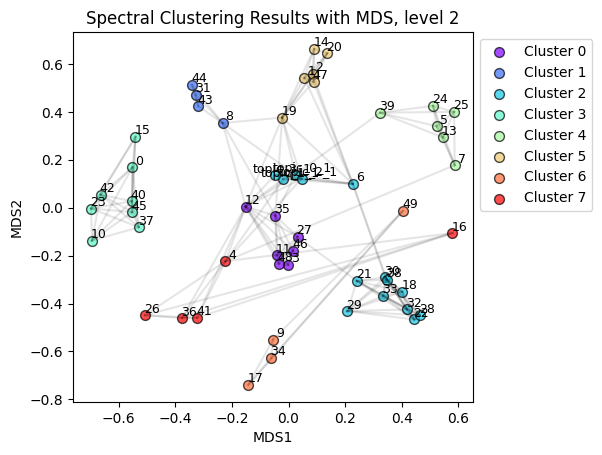

doc_names  cluster_id  max_p_topic_id
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           0               1
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           0               1
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           0               1
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure           0               1
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           0               1
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           0               1
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           0               1
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           1               4
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           1               4
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           1               4
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           1               4
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           2               1
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           2               2
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           2               2
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           2               2
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models           2               2
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           2               2
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           2               2
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           2               2
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           2               2
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           2               7
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           3               5
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           3               5
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           3               5
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar           3               5
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications           3               5
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope           3               5
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor           3               5
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa           3               5
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           4               0
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           4               0
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           4               0
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           4               0
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           4 

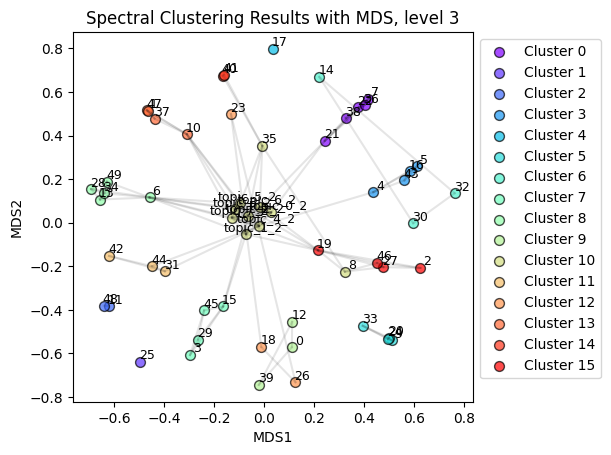

doc_names  cluster_id  max_p_topic_id
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           0               7
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           0               7
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           0               7
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           0               7
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           0               7
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           1               0
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           2               2
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           2               2
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           3               5
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           3               5
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex           3               5
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           3               5
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-           4               1
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and           5               6
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l           5               6
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           5               6
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           5               6
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease           6              15
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           6              15
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           6              15
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           7               3
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           7               3
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models           7               3
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa           7               3
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           8              10
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           8              10
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           8              10
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           8              10
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system           8              10
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           9               9
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           9               9
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           9               9
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction          10               4
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis          10 

In [96]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth',100)
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(model.get_level(level_id), doc_names=doc_names, labels=labels)
    display(df.sort_values(by=['cluster_id', 'max_p_topic_id']))

### Figure 5. Topic hierarchy structure - bioinformatics dataset

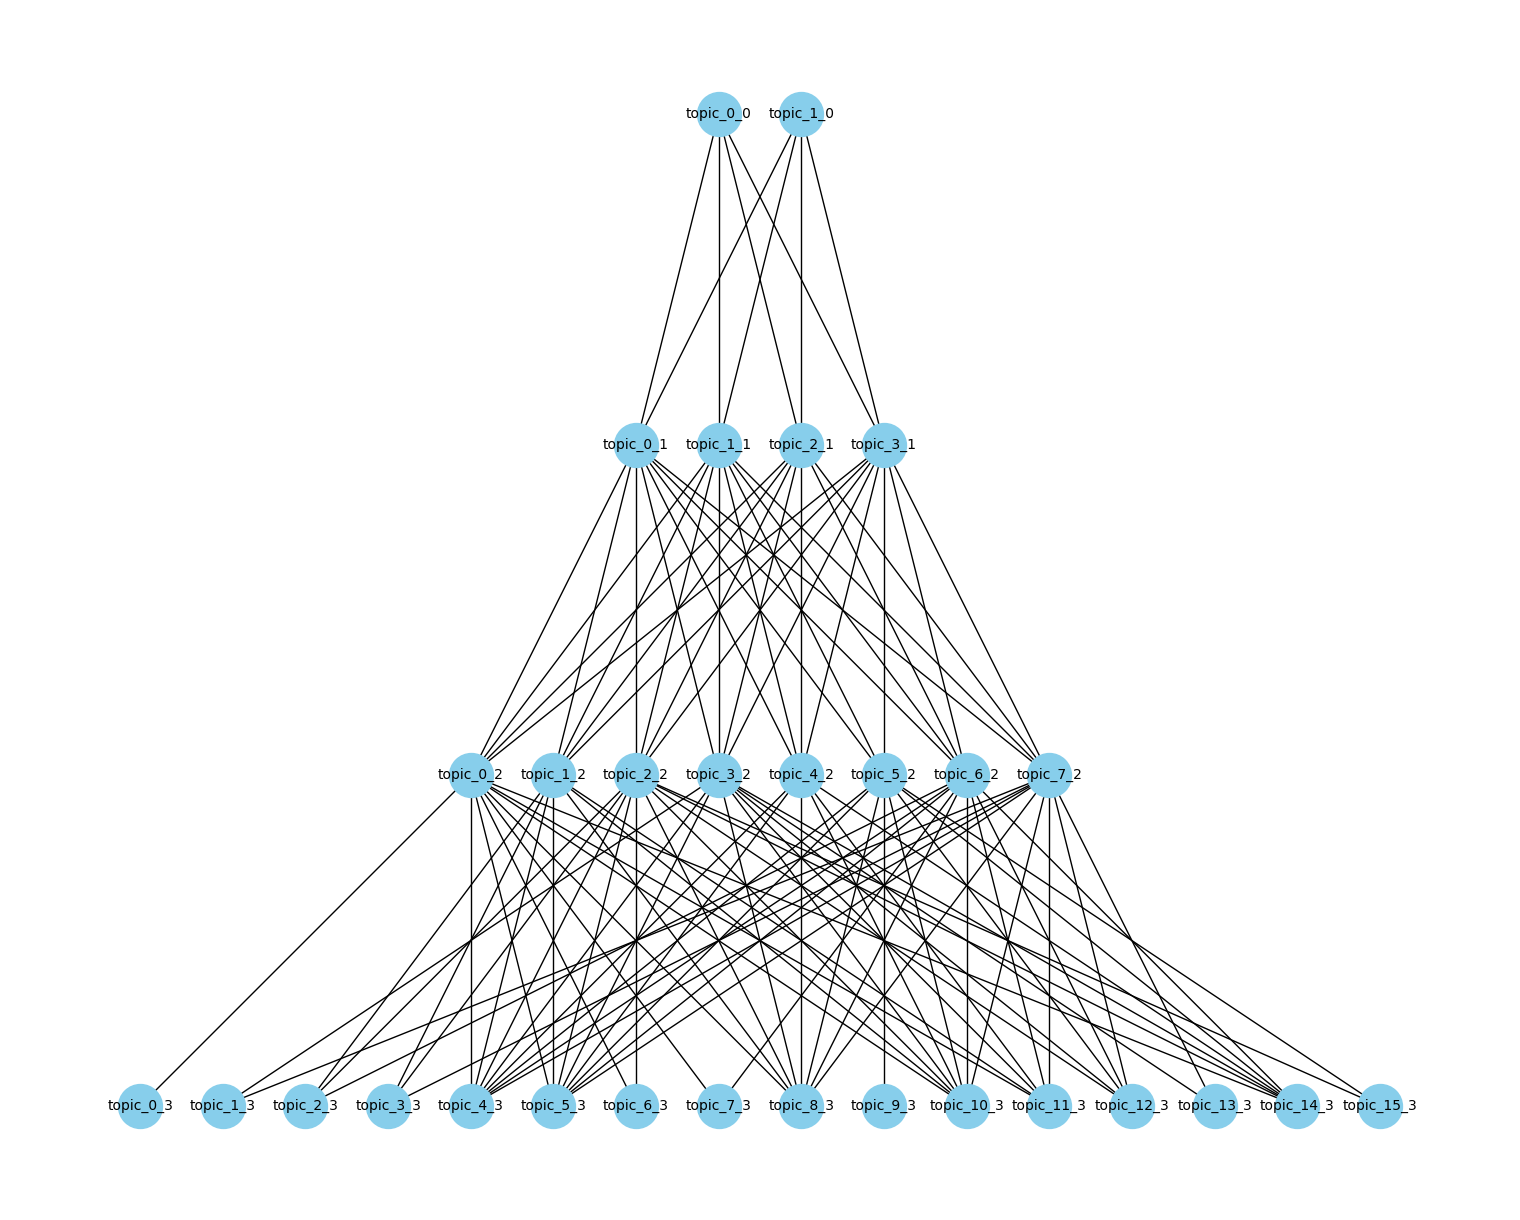

In [89]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(model, num_levels, threshold=0.05)

# Results for NLP set

In [79]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [80]:
#Preparing list of document names
with open(f'{input_folder}nlp_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

In [81]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [82]:
%%time
#Training the model
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 54.9 s, sys: 15.2 s, total: 1min 10s
Wall time: 26.3 s


In [83]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(model, num_levels)


level0

topic_0:  ['data', 'network', 'social', 'used', 'learning', 'spam', 'information', 'embedding', 'networks', 'research']
topic_1:  ['model', 'proceedings', 'conference', 'information', 'learning', 'knowledge', 'text', 'language', 'data', 'methods']

level1

topic_0:  ['data', 'network', 'embedding', 'information', 'news', 'graph', 'clustering', 'learning', 'models', 'networks']
topic_1:  ['clinical', 'social', 'patent', 'text', 'model', 'classification', 'data', 'spam', 'learning', 'detection']
topic_2:  ['knowledge', 'model', 'articles', 'tax', 'used', 'training', 'disease', 'set', 'research', 'quality']
topic_3:  ['proceedings', 'conference', 'language', 'extraction', 'computational', 'knowledge', 'association', 'linguistics', 'learning', 'methods']

level2

topic_0:  ['clustering', 'areas', 'topic', 'institutions', 'recommendation', 'terms', 'thematic', 'technology', 'performance', 'recommendations']
topic_1:  ['model', 'text', 'information', 'used', 'models', 'using', 'clin

### Figure 6. Quality metrics accross training iterations for hierarchical model - bioinformatics dataset


Results for level 0

Sparsity Phi: 0.373 
Sparsity Theta: 0.000
Kernel contrast: 0.871
Kernel purity: 0.914


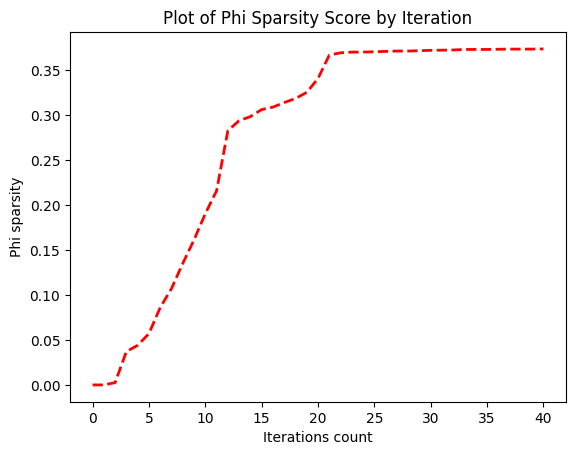

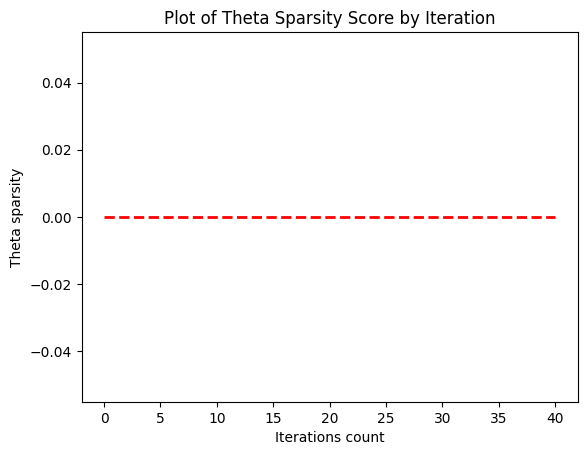

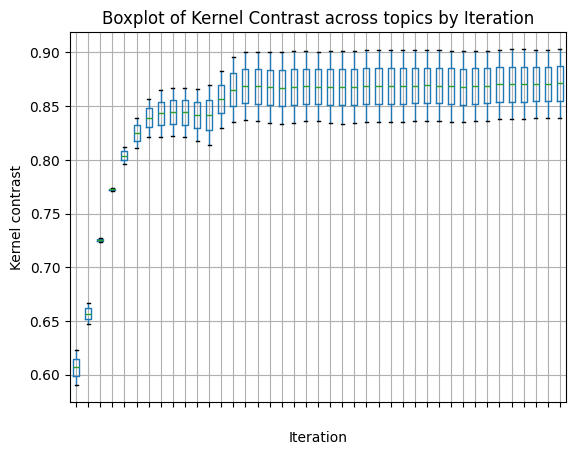

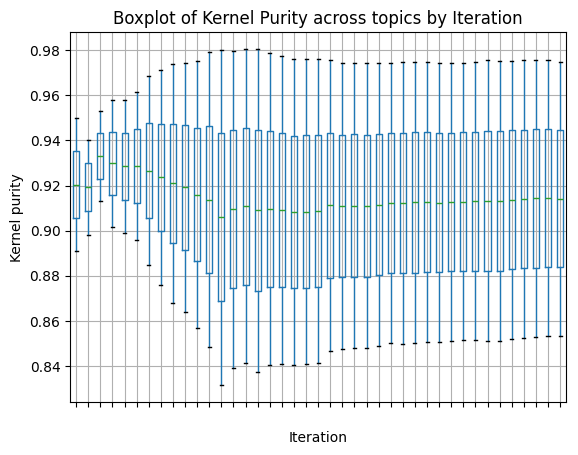

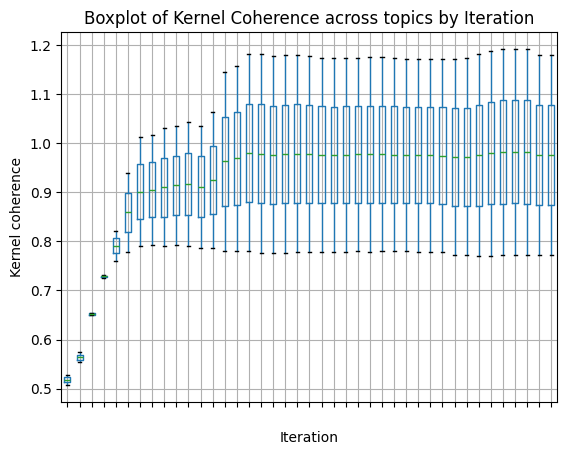


Results for level 1

Sparsity Phi: 0.570 
Sparsity Theta: 0.000
Kernel contrast: 0.827
Kernel purity: 0.780


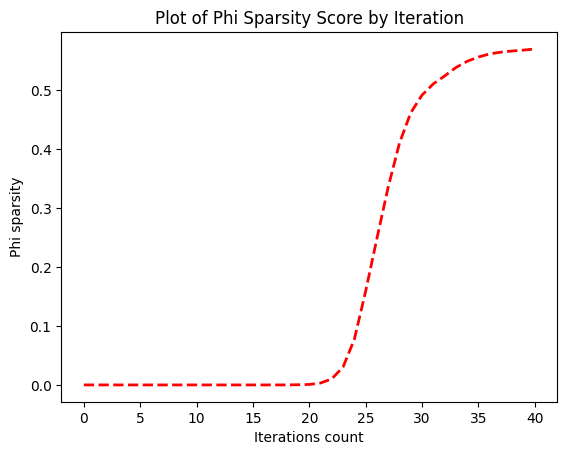

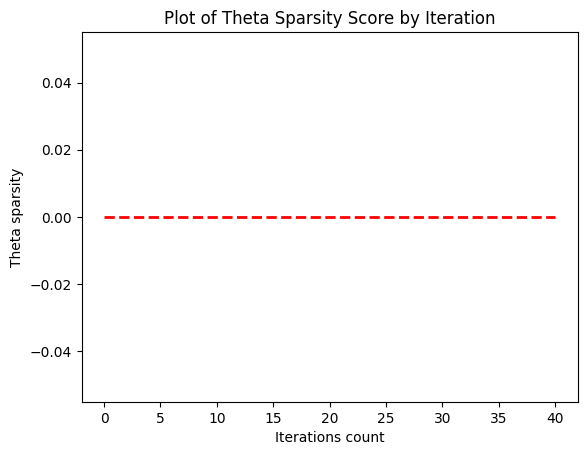

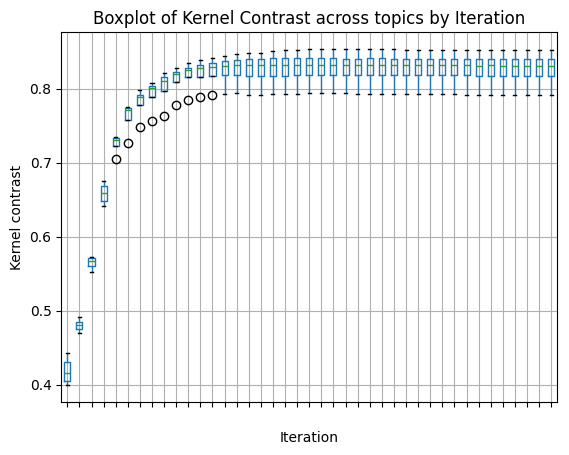

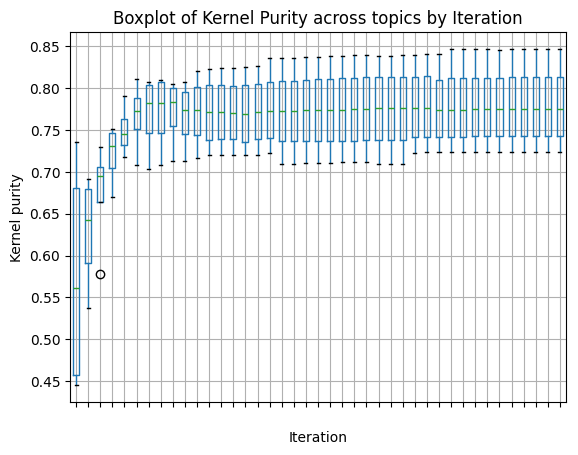

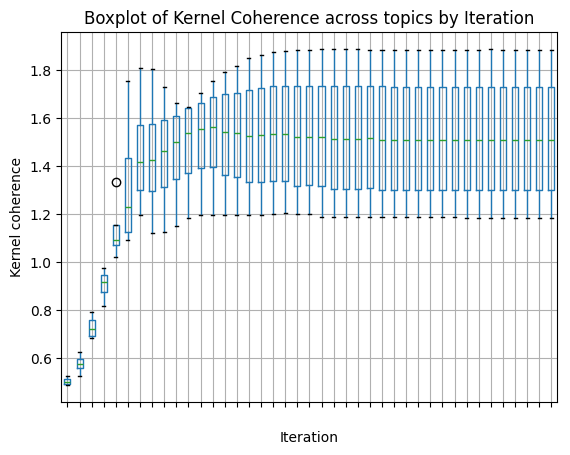


Results for level 2

Sparsity Phi: 0.686 
Sparsity Theta: 0.000
Kernel contrast: 0.816
Kernel purity: 0.787


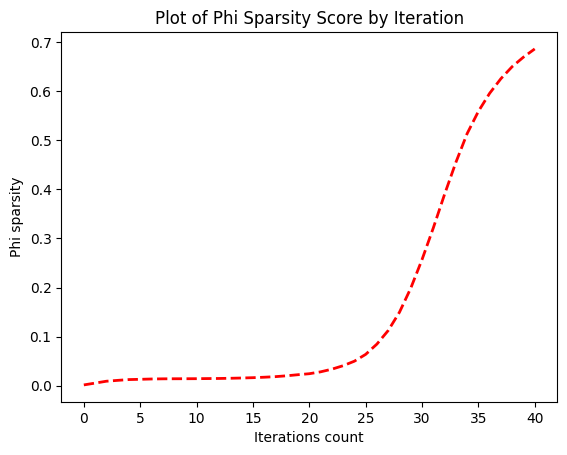

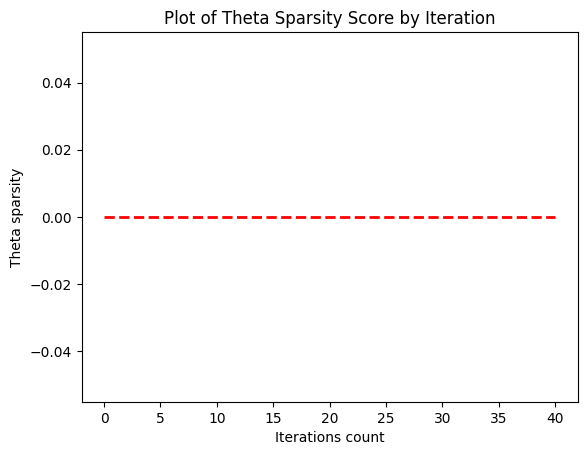

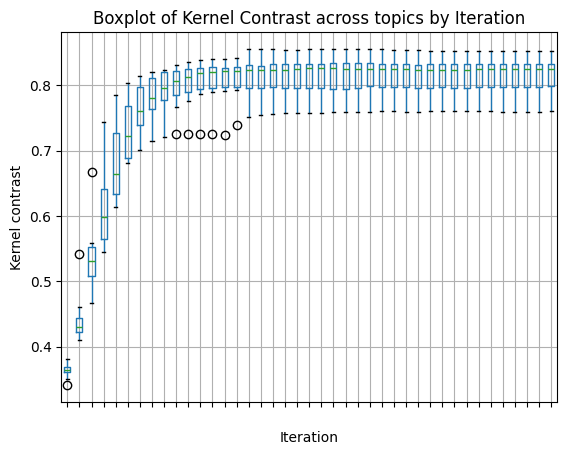

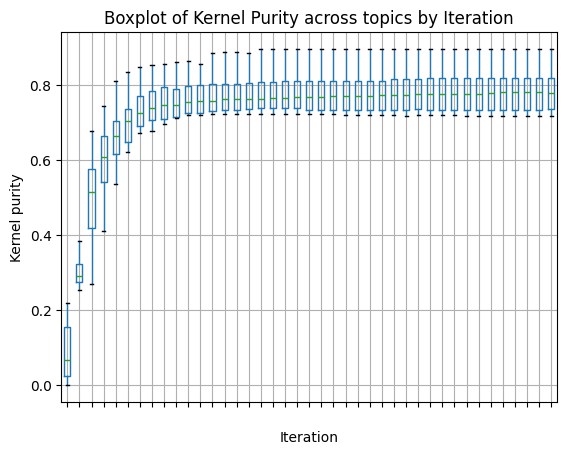

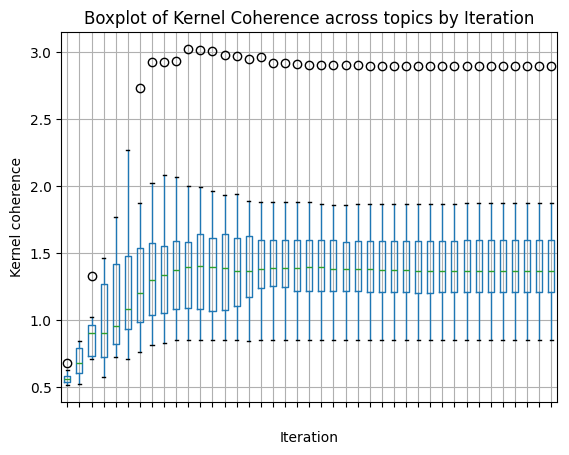


Results for level 3

Sparsity Phi: 0.000 
Sparsity Theta: 0.000
Kernel contrast: 0.471
Kernel purity: 0.402


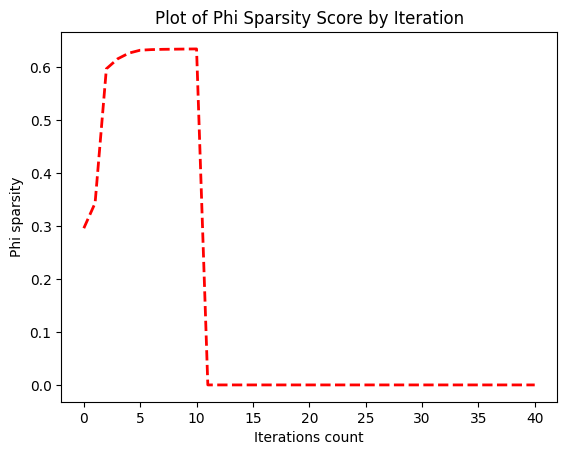

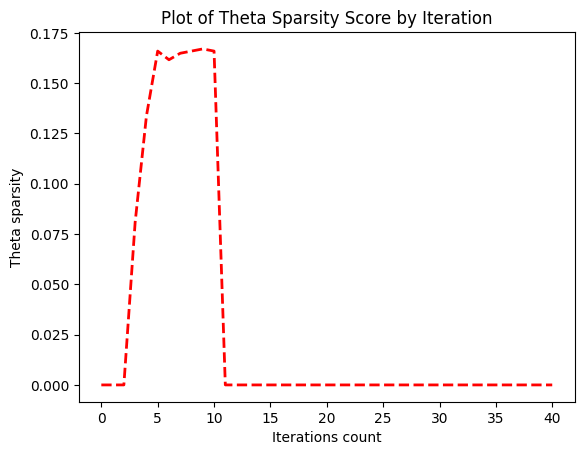

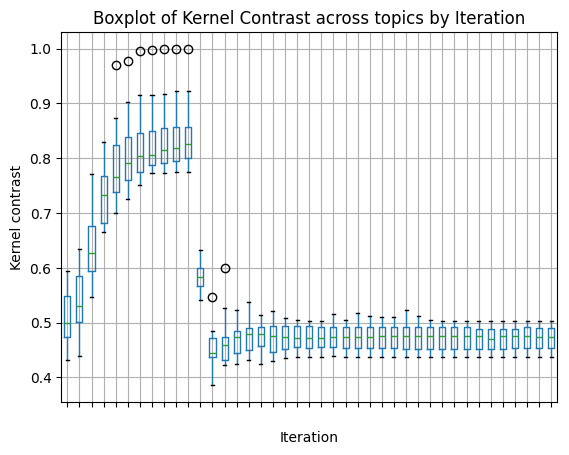

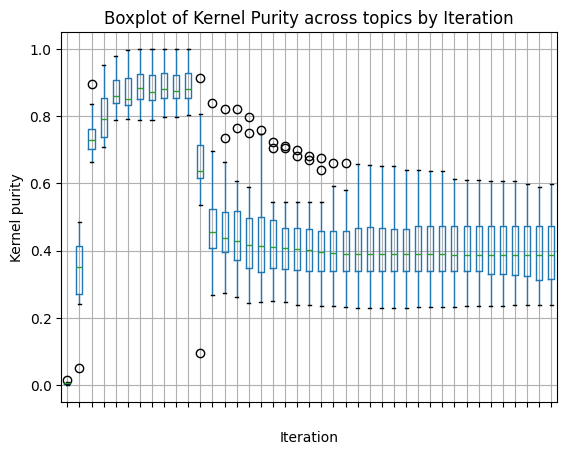

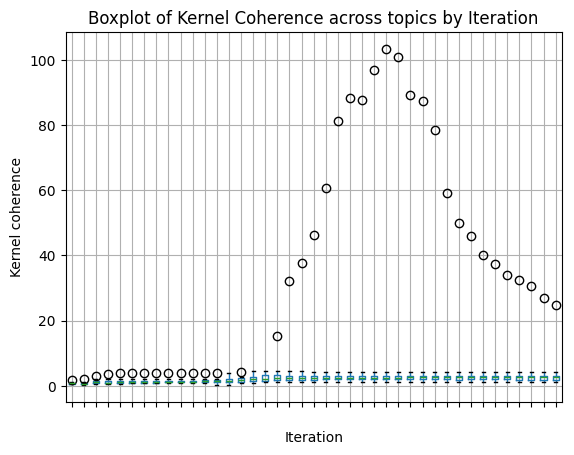

In [84]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(model.get_level(level_id))

### Figure 7. Spectral clustering results - NLP dataset

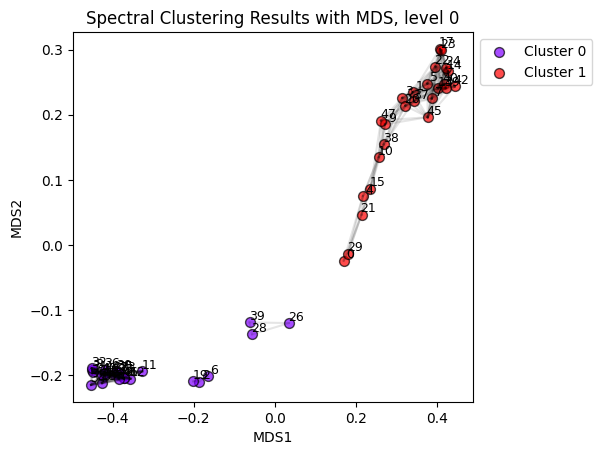

doc_names  cluster_id  max_p_topic_id
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic           0               1
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           0               1
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           0               1
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           0               1
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           0               1
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex           0               1
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           0               1
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome           0               1
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           0               1
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk           0               1
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure           0               1
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           0               1
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           0               1
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           0               1
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           0               1
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           0               1
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           0               1
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           0               1
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           0               1
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           0               1
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati           0               1
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           0               1
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           0               1
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           0               1
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           0               1
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           1               0
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review           1               0
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           1               0
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           1               0
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           1               0
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           1               0
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and           1               0
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           1               0
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           1 

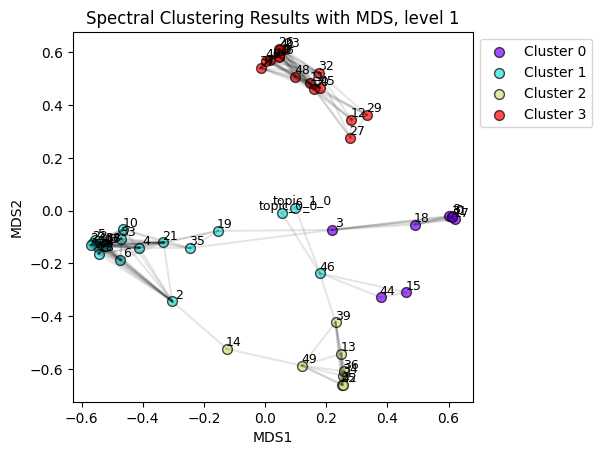

doc_names  cluster_id  max_p_topic_id
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           0               2
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           0               3
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           0               3
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           0               3
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           0               3
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-           0               3
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           0               3
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           0               3
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review           1               0
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic           1               0
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           1               0
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           1               0
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           1               0
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           1               0
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome           1               0
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l           1               0
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           1               0
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           1               0
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           1               0
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           1               0
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           1               0
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           1               0
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           1               0
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           1               0
47               Zhao_et_al._-_2021_-_Entropy-aware_self-training_for_graph_convolutiona           1               0
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           1               2
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           2               2
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease           2               2
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           2               2
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           2               2
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           2               2
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           2               2
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor           2               2
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system           2 

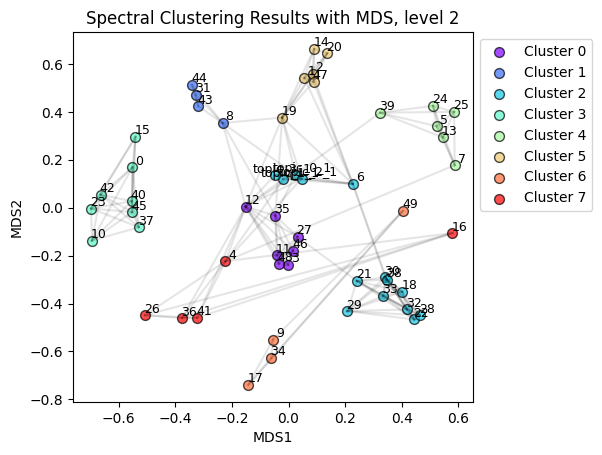

doc_names  cluster_id  max_p_topic_id
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           0               1
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           0               1
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           0               1
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure           0               1
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis           0               1
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc           0               1
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           0               1
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction           1               4
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques           1               4
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           1               4
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey           1               4
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           2               1
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl           2               2
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           2               2
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           2               2
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models           2               2
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           2               2
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           2               2
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           2               2
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           2               2
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           2               7
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           3               5
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect           3               5
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           3               5
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar           3               5
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications           3               5
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope           3               5
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor           3               5
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa           3               5
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           4               0
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           4               0
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           4               0
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           4               0
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           4 

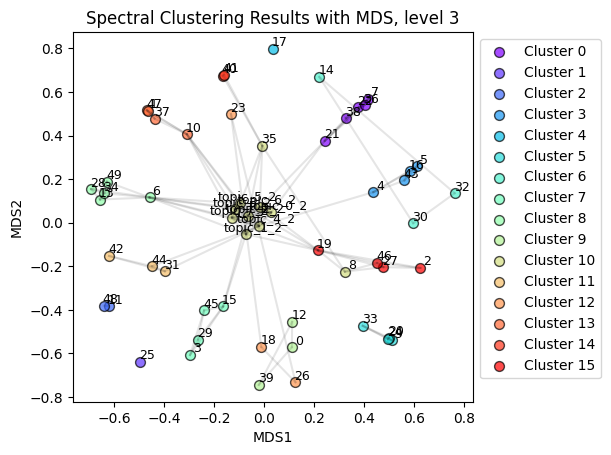

doc_names  cluster_id  max_p_topic_id
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas           0               7
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now           0               7
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui           0               7
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question           0               7
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data           0               7
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp           1               0
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification           2               2
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label           2               2
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit           3               5
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod           3               5
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex           3               5
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_           3               5
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-           4               1
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and           5               6
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l           5               6
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu           5               6
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur           5               6
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease           6              15
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_           6              15
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_           6              15
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr           7               3
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl           7               3
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models           7               3
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa           7               3
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l           8              10
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s           8              10
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex           8              10
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local           8              10
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system           8              10
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc           9               9
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review           9               9
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi           9               9
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction          10               4
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis          10 

In [97]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(model.get_level(level_id), doc_names=doc_names, labels=labels)
    display(df.sort_values(by=['cluster_id', 'max_p_topic_id']))

### Figure 8. Topic hierarchy structure - NLP dataset

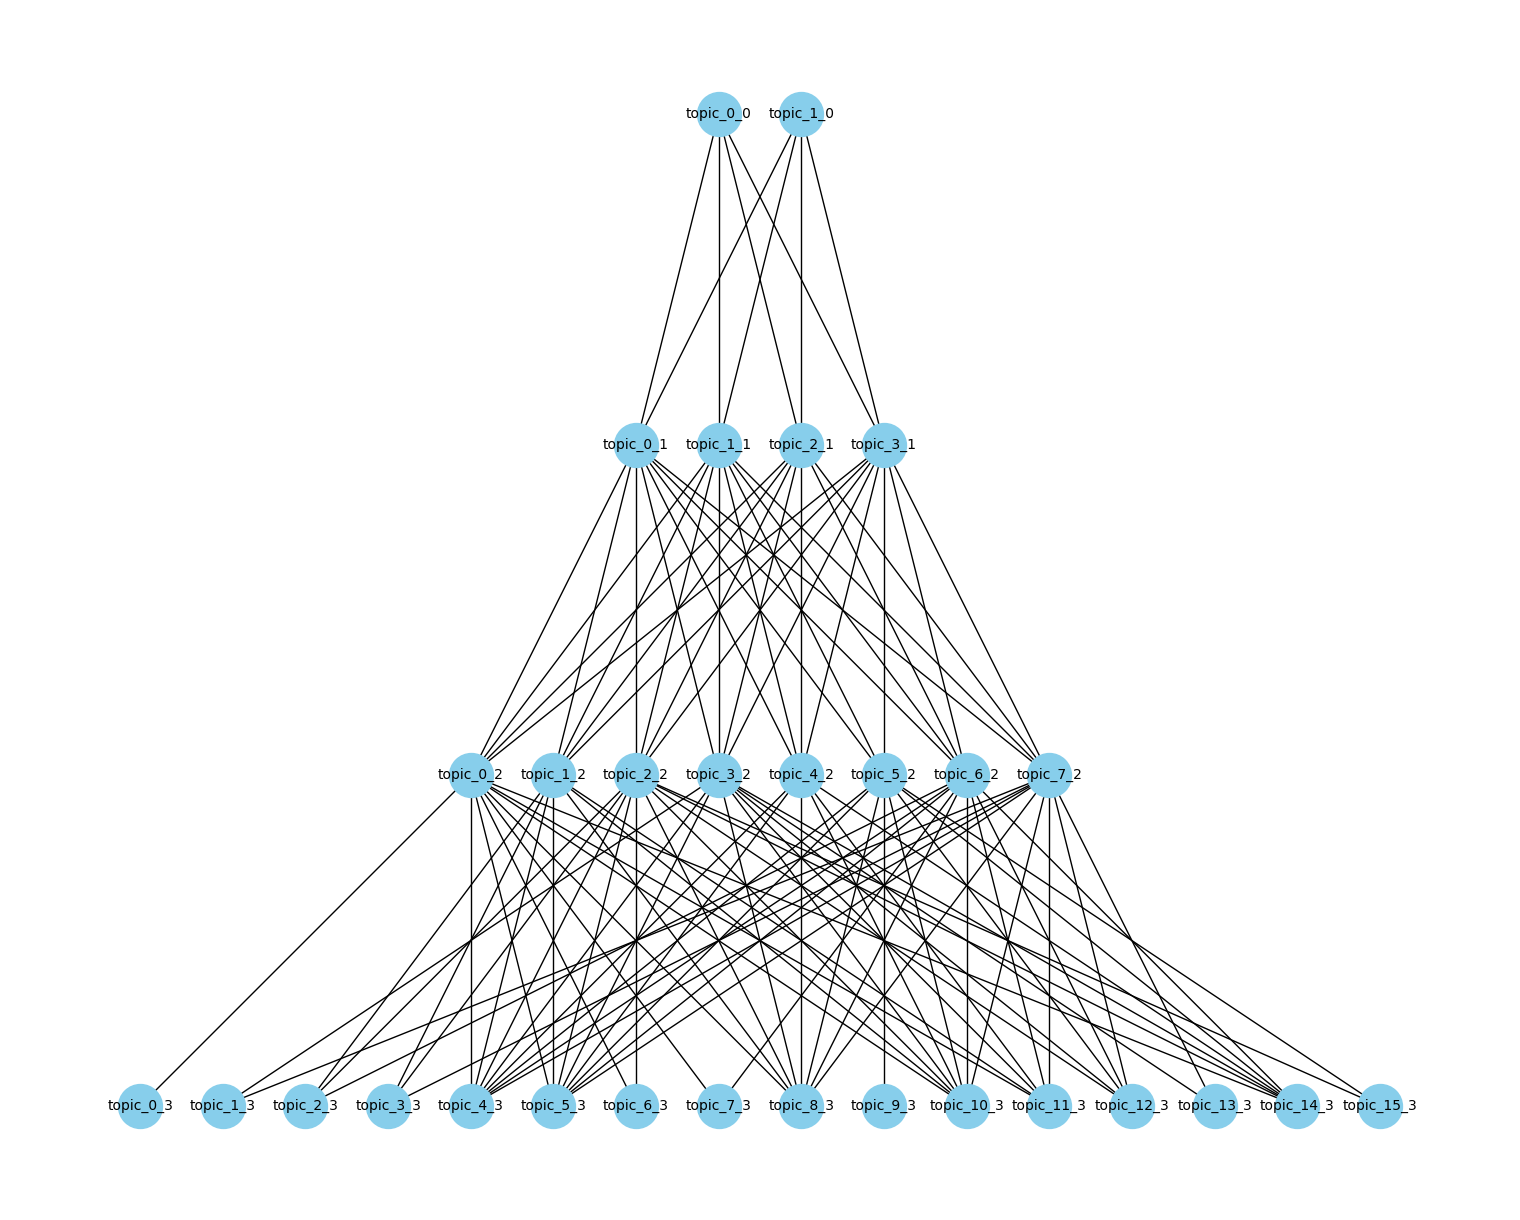

In [86]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(model, num_levels, threshold=0.05)